#  scTRaCT: Performing cell type annotation for **BMMCs** dataset Demo

In this notebook, we demonstrate how to use the `scTRaCT` framework for cell type identification from single-cell transcriptomic data.

To ensure a smooth and reproducible experience, please follow the steps below before proceeding:

### 1. Create a New Environment

It is recommended to use a clean environment (e.g., via `conda` or `venv`) to avoid version conflicts.

### 2. Install Required Dependencies

Install all required packages using the `requirements.txt` file provided in the repository:

```bash
pip install -r requirements.txt
```
This will ensure that all dependencies — including `scanpy`, `torch`, `anndata`, and `tqdm` — are properly installed.

### 3. Install scTRaCT Package

After installing the required packages, you also need to install the `scTRaCT` package itself.  
You can install it directly from GitHub using:

```bash
pip install git+https://github.com/msmalmir/scTRaCT.git
```
This will make all scTRaCT modules (prepare_data, TransformerModel, etc.) available for import.

### 4. Import Necessary Modules

Once the environment is set up and all dependencies are installed, import the required modules that will be used throughout the notebook:


In [8]:
import scanpy as sc
import torch
from torch.utils.data import DataLoader, TensorDataset
import os
import pandas as pd
from scTRaCT.preprocessing import prepare_data
from scTRaCT.model import TransformerModel, FocalLoss
from scTRaCT.trainer import train_model, evaluate_model, evaluate_on_query

## Usage Instructions

Before using `scTRaCT`, you need to provide the directory path to your preprocessed dataset stored in `.h5ad` format.  
This dataset should include **both training and test cells**.

If your training and test data are currently stored separately, please **concatenate them** into a single `AnnData` object and add a column in `adata.obs` named **is_train_key** (`is_train` could be a proper name) to distinguish them:

- Training samples should have: **is_train_key** = `'train'`
- Test/query samples can have any other value (e.g., `'test'`, `'query'`, or `False`)

You must also specify the name of the column containing ground truth cell type labels **cell_type_key** (e.g., `"cell_type"`).

---

### `prepare_data()` Parameters

```python
prepare_data(
    adata,
    lognorm_layer="lognorm",
    distance_layer="distance_matrix",
    cell_type_key="cell_type",
    is_train_key="is_train",
    j=30
)
```
| Parameter        | Description                                                                     |
|------------------|---------------------------------------------------------------------------------|
| `adata`          | `AnnData` object containing both training and test/query cells                 |
| `lognorm_layer`  | Name of the layer where log-normalized gene expression is stored               |
| `distance_layer` | Name of the layer to store or retrieve the MCA-based distance matrix           |
| `cell_type_key`  | Column in `adata.obs` for cell type labels                                     |
| `is_train_key`   | Column in `adata.obs` that distinguishes training and test/query samples       |
| `j`              | Number of MCA dimensions to use (default = 30)                                 |

---

## Configurable Model Parameters

When creating a `TransformerModel`, you may modify the architecture by specifying the following:

```python
TransformerModel(
    num_genes=...,
    num_classes=...,
    num_heads=8,
    dim_feedforward=2048,
    dropout=0.1,
    embedding_dim=1024
)
```


| Parameter         | Description                                                   |
|------------------|---------------------------------------------------------------|
| `num_heads`       | Number of attention heads (default = 8)                       |
| `dim_feedforward` | Size of the feedforward layer (default = 2048)               |
| `dropout`         | Dropout rate for regularization (default = 0.1)              |
| `embedding_dim`   | Dimensionality of gene and distance embeddings (default = 1024) |

---

##  Optional Training Hyperparameters

You can also modify these during training:

- `learning_rate`: Learning rate for the optimizer (default: `1e-5`)
- `gamma`: Focal loss focusing parameter for class imbalance (e.g., `2.0` to `2.5`)

In [4]:
# Set paths
adata_path = '/home/utsajinlab/onedrive_my_utsa/Second Project/scGPT exploration/datasets/BMMCs/BMMCs_data_preprocessed_HVG.h5ad'  
save_dir = "/home/utsajinlab/onedrive_my_utsa/Second Project/My_Models/Codes/saved_models"
save_name = "scTRaCT_checkpoint"

lognorm_layer = "lognorm"
distance_layer = "distance_matrix"
cell_type_key = "cell_type"
is_train_key = "is_train"

num_epochs = 50
save_every = 10
batch_size = 64
num_heads = 8
dim_feedforward = 2048 
dropout = 0.1
embedding_dim = 1024
lr = 1e-5
gamma = 2.5

# Load AnnData
adata = sc.read_h5ad(adata_path)

# Prepare data (will calculate distance if not present)
X_train_counts, X_train_dist, y_train, X_val_counts, X_val_dist, y_val, label_encoder = prepare_data(adata, lognorm_layer=lognorm_layer, 
                                                                                                     distance_layer=distance_layer, 
                                                                                                     cell_type_key=cell_type_key, 
                                                                                                     is_train_key=is_train_key, j=30)

# Create DataLoaders
train_dataset = TensorDataset(X_train_counts, X_train_dist, y_train)
val_dataset = TensorDataset(X_val_counts, X_val_dist, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_genes = X_train_counts.shape[1]
num_classes = len(label_encoder.classes_)

model = TransformerModel(
    num_genes=num_genes,
    num_classes=num_classes,
    num_heads=num_heads,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    embedding_dim=embedding_dim
)

model = model.to(device)

# Loss and optimizer
criterion = FocalLoss(gamma=gamma)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Train model
train_model(
    model, train_loader, val_loader, 
    criterion, optimizer, num_epochs=num_epochs, 
    save_dir=save_dir, save_every=save_every, save_name=save_name
)



Calculating distance matrix using MCA...


[ Train | 001/050 ] loss = 0.66963, acc = 0.74875, f1 = 0.45330


[ Train | 002/050 ] loss = 0.33159, acc = 0.83821, f1 = 0.61720


[ Train | 003/050 ] loss = 0.25033, acc = 0.86235, f1 = 0.68640


[ Train | 004/050 ] loss = 0.20587, acc = 0.88035, f1 = 0.73379


[ Train | 005/050 ] loss = 0.16641, acc = 0.89497, f1 = 0.76603


[ Train | 006/050 ] loss = 0.13533, acc = 0.90924, f1 = 0.81137


[ Train | 007/050 ] loss = 0.10834, acc = 0.92172, f1 = 0.83669


[ Train | 008/050 ] loss = 0.08443, acc = 0.93645, f1 = 0.87169


[ Train | 009/050 ] loss = 0.07047, acc = 0.94566, f1 = 0.89470


[ Train | 010/050 ] loss = 0.05676, acc = 0.95546, f1 = 0.91768
Model saved at /home/utsajinlab/onedrive_my_utsa/Second Project/My_Models/Codes/saved_models/scTRaCT_checkpoint_epoch10.pth


[ Train | 011/050 ] loss = 0.04485, acc = 0.96203, f1 = 0.93106


[ Train | 012/050 ] loss = 0.04096, acc = 0.96636, f1 = 0.93330


[ Train | 013/050 ] loss = 0.03434, acc = 0.97154, f1 = 0.94276


[ Train | 014/050 ] loss = 0.02601, acc = 0.97718, f1 = 0.95706


[ Train | 015/050 ] loss = 0.02525, acc = 0.97820, f1 = 0.95968


[ Train | 016/050 ] loss = 0.02411, acc = 0.98044, f1 = 0.96526


[ Train | 017/050 ] loss = 0.02259, acc = 0.98231, f1 = 0.96780


[ Train | 018/050 ] loss = 0.01682, acc = 0.98469, f1 = 0.97049


[ Train | 019/050 ] loss = 0.01573, acc = 0.98587, f1 = 0.97452


[ Train | 020/050 ] loss = 0.01604, acc = 0.98672, f1 = 0.97432
Model saved at /home/utsajinlab/onedrive_my_utsa/Second Project/My_Models/Codes/saved_models/scTRaCT_checkpoint_epoch20.pth


[ Train | 021/050 ] loss = 0.01595, acc = 0.98725, f1 = 0.97052


[ Train | 022/050 ] loss = 0.01255, acc = 0.98884, f1 = 0.97734


[ Train | 023/050 ] loss = 0.01236, acc = 0.98952, f1 = 0.98002


[ Train | 024/050 ] loss = 0.01206, acc = 0.98982, f1 = 0.98056


[ Train | 025/050 ] loss = 0.01214, acc = 0.99020, f1 = 0.98078


[ Train | 026/050 ] loss = 0.00966, acc = 0.99154, f1 = 0.98277


[ Train | 027/050 ] loss = 0.00962, acc = 0.99222, f1 = 0.98726


[ Train | 028/050 ] loss = 0.01011, acc = 0.99158, f1 = 0.98348


[ Train | 029/050 ] loss = 0.00941, acc = 0.99192, f1 = 0.98442


[ Train | 030/050 ] loss = 0.00678, acc = 0.99412, f1 = 0.98982
Model saved at /home/utsajinlab/onedrive_my_utsa/Second Project/My_Models/Codes/saved_models/scTRaCT_checkpoint_epoch30.pth


[ Train | 031/050 ] loss = 0.00855, acc = 0.99273, f1 = 0.98480


[ Train | 032/050 ] loss = 0.00748, acc = 0.99357, f1 = 0.98903


[ Train | 033/050 ] loss = 0.00840, acc = 0.99353, f1 = 0.98532


[ Train | 034/050 ] loss = 0.00620, acc = 0.99444, f1 = 0.98789


[ Train | 035/050 ] loss = 0.00630, acc = 0.99465, f1 = 0.98976


[ Train | 036/050 ] loss = 0.00831, acc = 0.99438, f1 = 0.98769


[ Train | 037/050 ] loss = 0.00662, acc = 0.99512, f1 = 0.98929


[ Train | 038/050 ] loss = 0.00736, acc = 0.99444, f1 = 0.99007


[ Train | 039/050 ] loss = 0.00749, acc = 0.99480, f1 = 0.98854


[ Train | 040/050 ] loss = 0.00528, acc = 0.99591, f1 = 0.99334
Model saved at /home/utsajinlab/onedrive_my_utsa/Second Project/My_Models/Codes/saved_models/scTRaCT_checkpoint_epoch40.pth


[ Train | 041/050 ] loss = 0.00653, acc = 0.99523, f1 = 0.99227


[ Train | 042/050 ] loss = 0.00694, acc = 0.99521, f1 = 0.99137


[ Train | 043/050 ] loss = 0.00473, acc = 0.99635, f1 = 0.99273


[ Train | 044/050 ] loss = 0.00507, acc = 0.99608, f1 = 0.99236


[ Train | 045/050 ] loss = 0.00514, acc = 0.99618, f1 = 0.99319


[ Train | 046/050 ] loss = 0.00601, acc = 0.99582, f1 = 0.99357


[ Train | 047/050 ] loss = 0.00495, acc = 0.99616, f1 = 0.99059


[ Train | 048/050 ] loss = 0.00559, acc = 0.99578, f1 = 0.98900


[ Train | 049/050 ] loss = 0.00502, acc = 0.99599, f1 = 0.99105


[ Train | 050/050 ] loss = 0.00394, acc = 0.99714, f1 = 0.99277
Model saved at /home/utsajinlab/onedrive_my_utsa/Second Project/My_Models/Codes/saved_models/scTRaCT_checkpoint_epoch50.pth


In [5]:
acc, f1, predicted_celltypes, query_adata = evaluate_on_query(
    adata=adata,
    checkpoint_path=f"{save_dir}/{save_name}_epoch50.pth",
    label_encoder=label_encoder, 
    lognorm_layer=lognorm_layer,
    distance_layer=distance_layer,
    cell_type_key=cell_type_key,
    is_train_key=is_train_key,
    num_heads=num_heads,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    embedding_dim=embedding_dim,
    batch_size=batch_size
)


Test/Query Set Accuracy: 0.8195
Test/Query Set F1 Score: 0.7447


##  Analyzing the Results

At this stage, the prediction step using the trained `scTRaCT` model has been completed. The remaining cells in this notebook are dedicated to evaluating and interpreting the results.

We will focus on two key aspects of analysis:

1. **Visualizing Cell Type Distributions with UMAP**  
   We will generate UMAP plots to visualize the spatial distribution of both the true cell type annotations and the predicted labels. This helps assess how well the model was able to recover biological structure and cluster boundaries in the latent space.

2. **Evaluating Classification Performance using a Confusion Matrix**  
   We will compute a confusion matrix to quantify the agreement between predicted and true labels. This matrix highlights the types of errors the model makes and provides insight into which cell types are being confused with others.

These visual and quantitative evaluations are essential for assessing the biological and technical relevance of the predictions produced by `scTRaCT`.


In [6]:
# Add predicted cell types to query_adata
query_adata.obs['predicted_celltypes'] = predicted_celltypes

## Loading the package and calculating the PCA and UMAP for query dataset 

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D


cell_type_key = "cell_type"
prediction_key = "predicted_celltypes"  # The key where your model predictions are stored
#save_path = "BMMCs_umap_true_vs_pred.pdf"


# Compute PCA if not already done
sc.tl.pca(query_adata)

# Compute neighbors
sc.pp.neighbors(query_adata, use_rep="X_pca")

# Now compute UMAP
sc.tl.umap(query_adata)

## Plot UMAP 
The uper plot is related to the true label and the below one is the cell types we have predicted using the **scTRaCT** algorithm

/tmp/ipykernel_1566342/2039848049.py:12: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_labels = pd.unique(query_adata.obs[cell_type_key].tolist() + query_adata.obs[prediction_key].tolist())


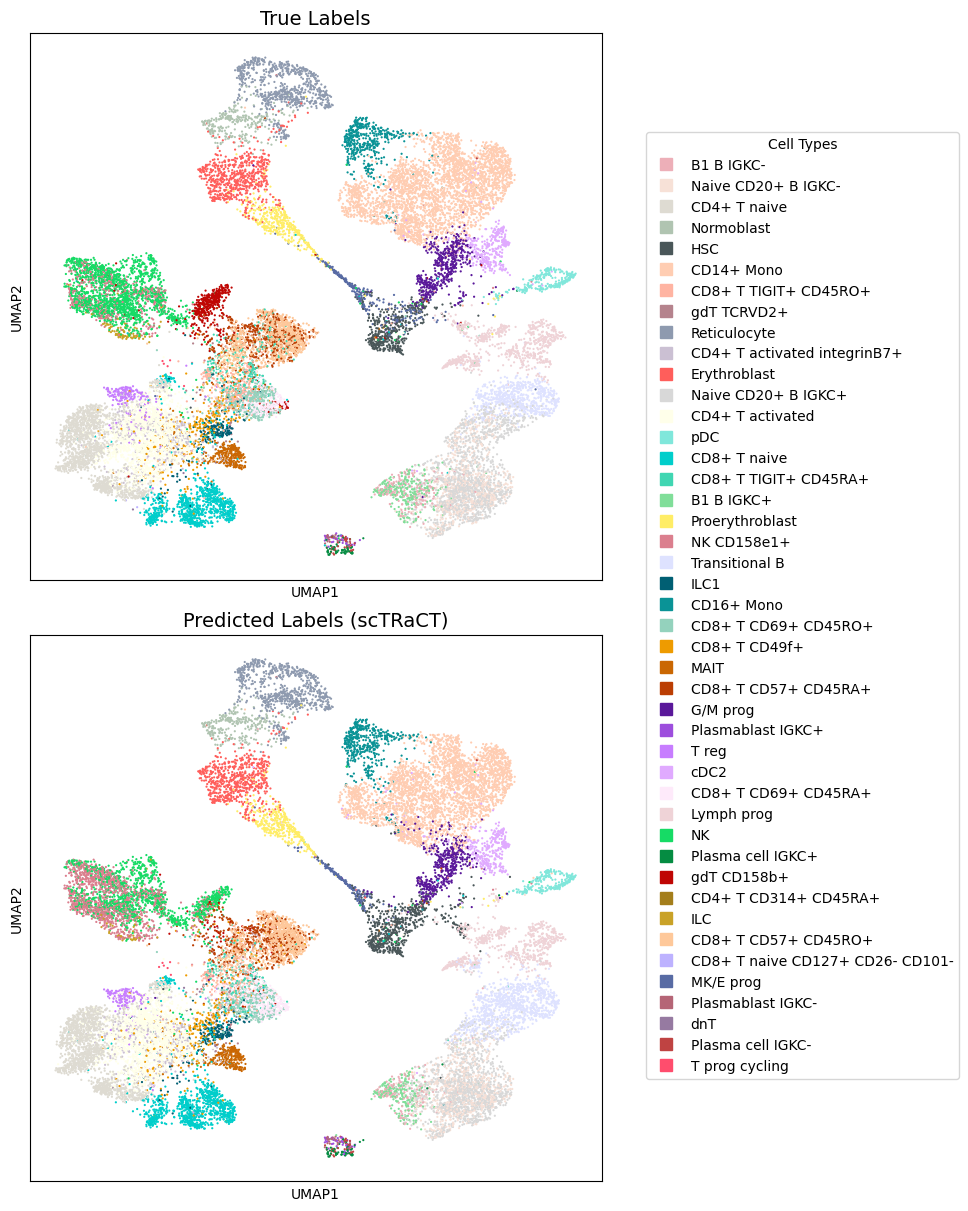

In [17]:
# Define custom palette
custom_palette = [
    "#edafb8", "#f7e1d7", "#dedbd2", "#b0c4b1", "#4a5759",
    "#ffcdb2", "#ffb4a2", "#b5838d", "#8e9aaf", "#cbc0d3",
    "#ff5e5b", "#d8d8d8", "#ffffea", "#80e7db", "#00cecb", "#40d6b2", "#80de99", "#ffed66", "#db7f8e", "#dee2ff",
    "#005f73", "#0a9396", "#94d2bd", "#ee9b00", "#ca6702", "#bb3e03", "#5a189a", "#9d4edd", "#c77dff", "#e0aaff",
    "#feeafa", "#efd3d7", "#16db65", "#058c42", "#bf0603", "#a47e1b", "#c9a227", "#fec89a", "#bdb2ff", "#586ba4",
    "#b56576", "#967aa1", "#bf4342", "#ff4d6d"
]

# Get all unique cell types from both true and predicted labels
unique_labels = pd.unique(query_adata.obs[cell_type_key].tolist() + query_adata.obs[prediction_key].tolist())

# Check if we have enough colors
if len(unique_labels) > len(custom_palette):
    raise ValueError("Not enough colors for all cell types.")

# Map labels to colors
color_map = dict(zip(unique_labels, custom_palette[:len(unique_labels)]))

# Create figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(6, 12), constrained_layout=True)

# Top plot: True labels
sc.pl.umap(
    query_adata, color=cell_type_key, palette=color_map, size=10, legend_loc=None, ax=axs[0], show=False
)
axs[0].set_title("True Labels", fontsize=14)

# Bottom plot: Predicted labels
sc.pl.umap(
    query_adata, color=prediction_key, palette=color_map, size=10, legend_loc=None, ax=axs[1], show=False
)
axs[1].set_title("Predicted Labels (scTRaCT)", fontsize=14)

# Create shared legend
handles = [
    Line2D([0], [0], marker='s', linestyle='None',
           markerfacecolor=color_map[label], markeredgecolor=color_map[label],
           markersize=8, label=label)
    for label in unique_labels
]

fig.legend(
    handles=handles, loc='center right', bbox_to_anchor=(1.6, 0.5), ncol=1, fontsize=10, title="Cell Types"
)

# Save the plot
#fig.savefig(save_path, bbox_inches="tight", dpi=300)
plt.show()

## Confusion Matrix

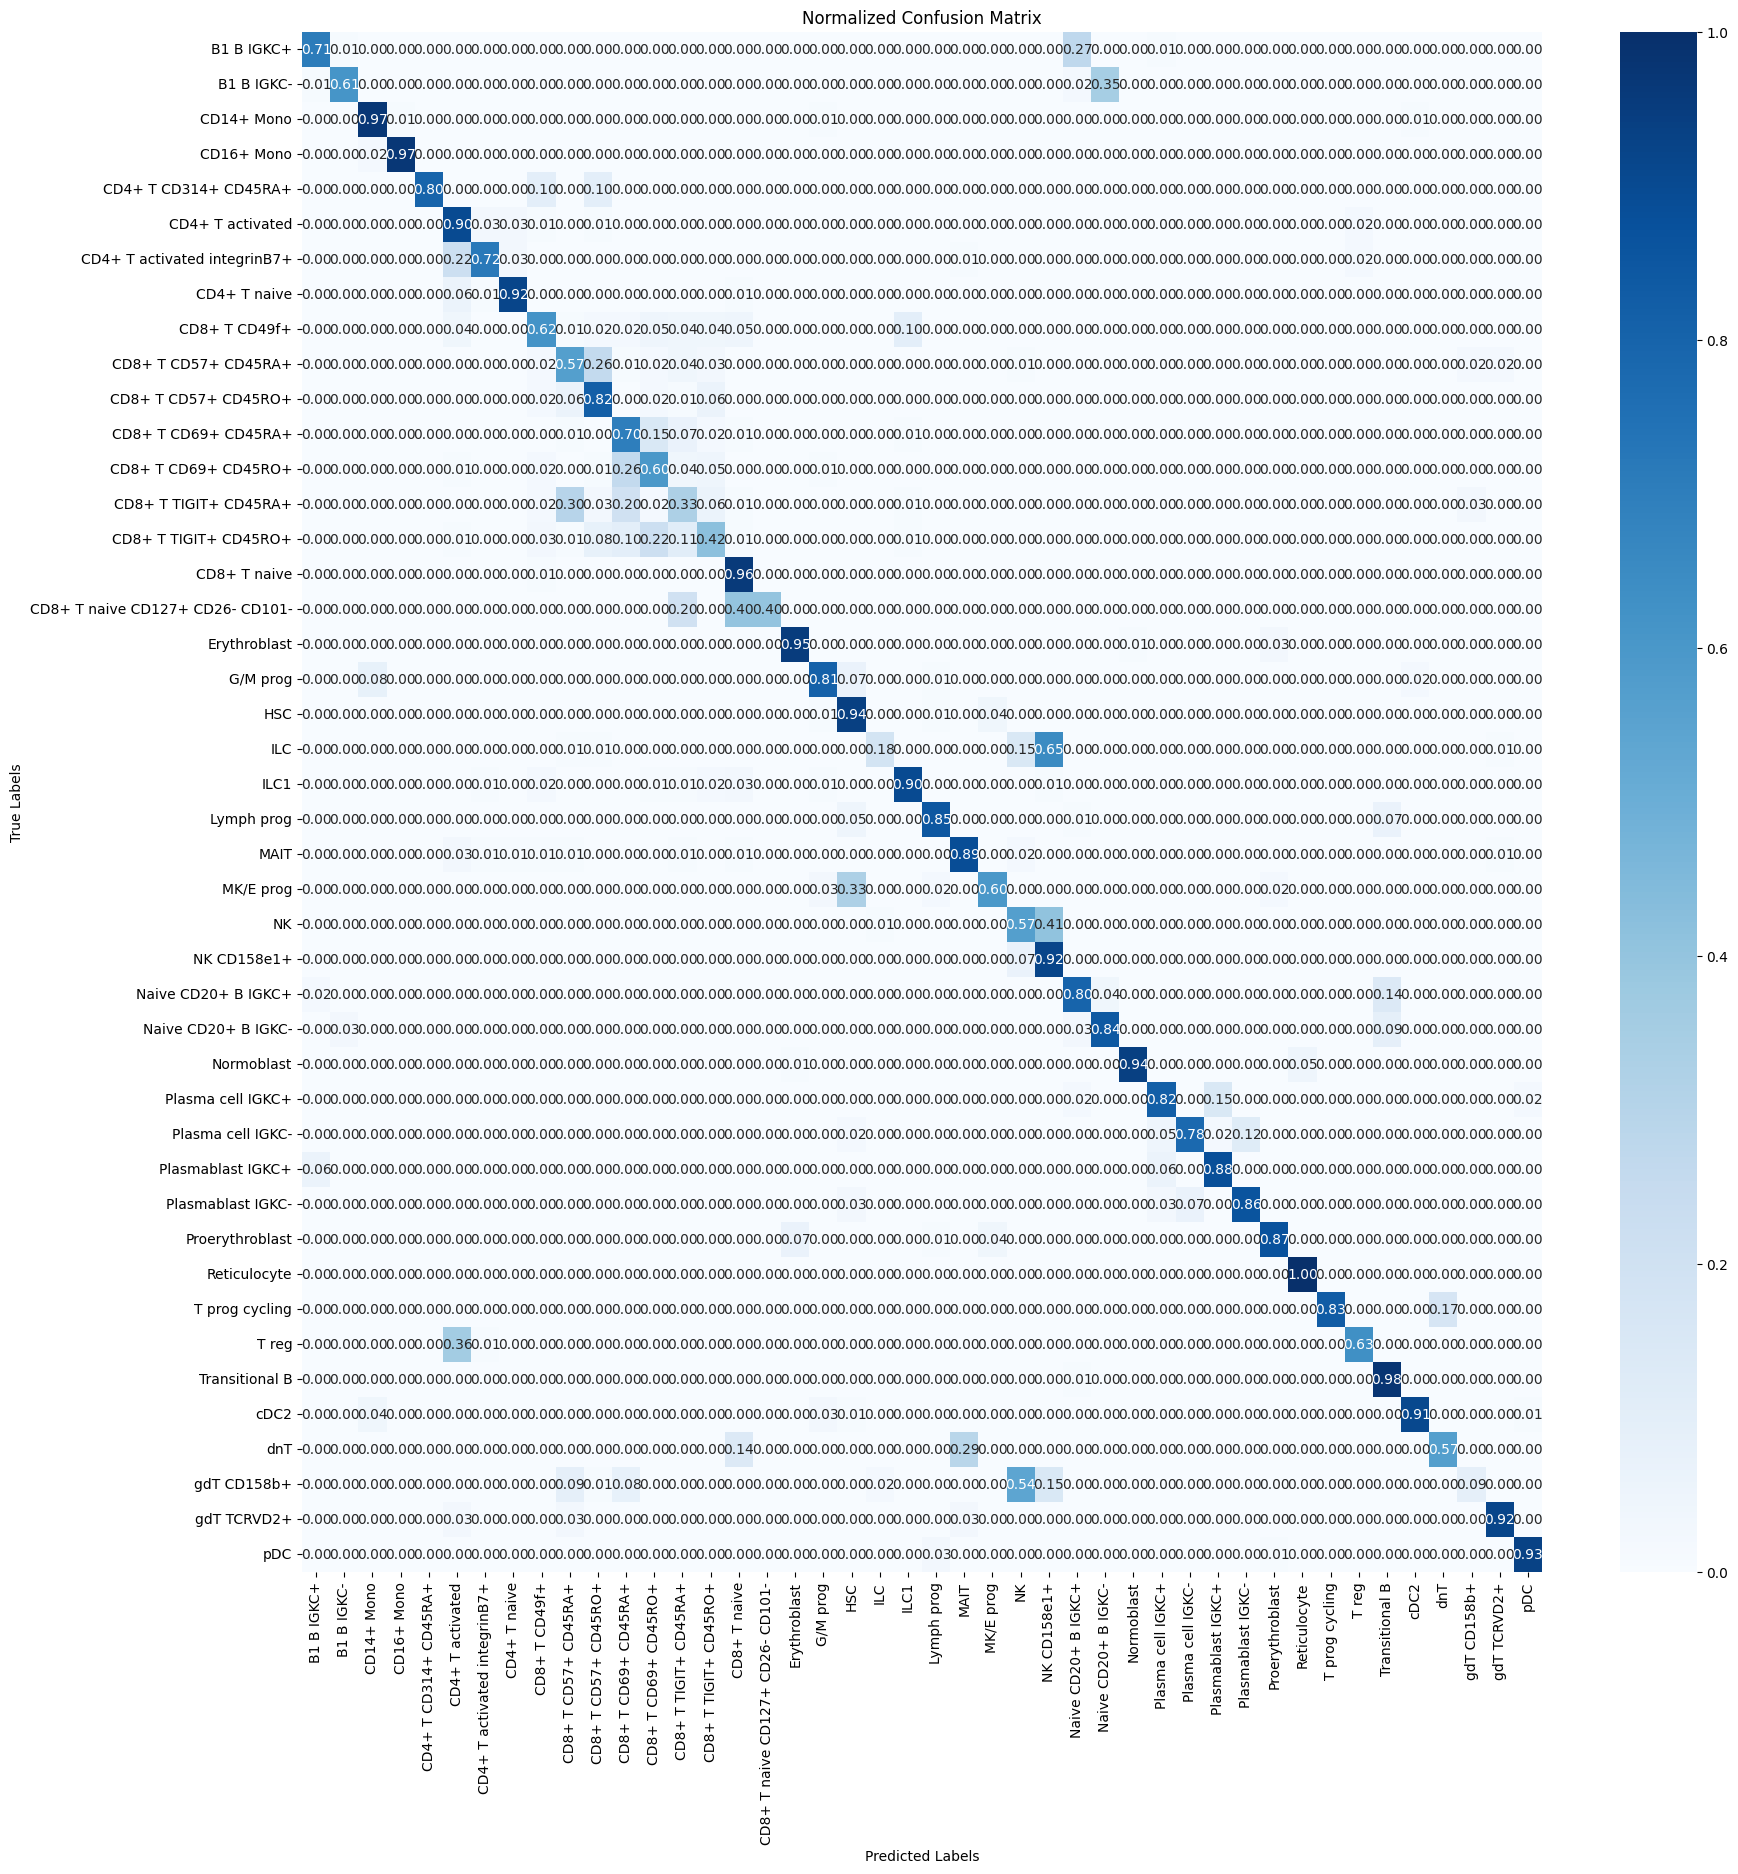

In [18]:
# Ensure celltype columns are categorical and handle NaNs as strings if needed
query_adata.obs[cell_type_key] = query_adata.obs[cell_type_key].astype('category')
query_adata.obs['predicted_celltypes'] = query_adata.obs['predicted_celltypes'].astype('category')

# Get the full set of unique labels
all_cell_types = np.union1d(query_adata.obs[cell_type_key].cat.categories, query_adata.obs['predicted_celltypes'].cat.categories)



# Create and normalize the confusion matrix
conf_matrix = confusion_matrix(query_adata.obs[cell_type_key], query_adata.obs['predicted_celltypes'], labels=all_cell_types)
conf_matrix_normalized = np.round(conf_matrix / conf_matrix.sum(axis=1, keepdims=True), 2)

# Plot the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix_normalized, annot=True, cmap="Blues", xticklabels=all_cell_types, yticklabels=all_cell_types, fmt='.2f')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
# Save the plot as a PNG file
# plt.savefig("/home/utsajinlab/onedrive_my_utsa/Second Project/My_Models/Results/BMMCs/BMMCs_confusion_matrix.pdf", dpi=600, bbox_inches='tight')  # You can change the path and file name
plt.show()